In [1]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
!python --version

Python 3.9.16


In [5]:
!dir

 Volume in drive D is Personal
 Volume Serial Number is D32B-FF30

 Directory of D:\DataScience\AllCode

06/01/2023  05:31 AM    <DIR>          .
06/01/2023  05:31 AM    <DIR>          ..
05/31/2023  12:23 AM                11 .gitignore
06/01/2023  05:31 AM    <DIR>          .ipynb_checkpoints
06/01/2023  05:18 AM    <DIR>          BasicTF
06/01/2023  04:55 AM    <DIR>          d2l-en
05/31/2023  12:20 AM            11,394 d2l-env-pip-packages.txt
05/31/2023  03:15 PM        16,434,005 DiveIntoDeepLearning.pdf
05/31/2023  03:15 PM        14,624,345 DiveIntoDeepLearningBeta.pdf
05/31/2023  03:38 PM                 0 jupyter-error.txt
05/31/2023  03:38 PM                 0 jupyter-out.txt
06/01/2023  05:27 AM             2,966 jupyter-p309-error.txt
06/01/2023  05:24 AM               159 jupyter-p309-out.txt
06/01/2023  05:18 AM    <DIR>          LinearRegression
06/01/2023  05:23 AM               131 start-jupyter-p309.bat
               9 File(s)     31,073,011 bytes
               6 

## Import Packages

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
import seaborn as sns
from scipy import stats
import scipy

## Read the data

In [10]:
url='https://drive.google.com/file/d/1dQtihjucMD-tT_qTan7KLNjNV5ZKT0zy/view?usp=drive_link'
file_id=url.split('/')[-2]
dwn_url='https://drive.google.com/uc?id=' + file_id

dfSoccer = pd.read_csv(dwn_url)

In [11]:
dfSoccer.head()

,PlayerName,Club,DistanceCovered(InKms),Goals,MinutestoGoalRatio,ShotsPerGame,AgentCharges,BMI,Cost,PreviousClubCost,Height,Weight,Score
0,"Braund, Mr. Owen Harris",MUN,3.96,7.5,37.5,12.3,60,20.56,109.1,63.32,195.9,78.9,19.75
1,"Allen, Mr. William Henry",MUN,4.41,8.3,38.2,12.7,68,20.67,102.8,58.55,189.7,74.4,21.30
2,"Moran, Mr. James",MUN,4.14,5.0,36.4,11.6,21,21.86,104.6,55.36,177.8,69.1,19.88
3,"McCarthy, Mr. Timothy J",MUN,4.11,5.3,37.3,12.6,69,21.88,126.4,57.18,185.0,74.9,23.66
4,"Palsson, Master. Gosta Leonard",MUN,4.45,6.8,41.5,14.0,29,18.96,80.3,53.20,184.6,64.6,17.64


In [12]:
dfSoccer.describe()

,DistanceCovered(InKms),Goals,MinutestoGoalRatio,ShotsPerGame,AgentCharges,BMI,Cost,PreviousClubCost,Height,Weight,Score
count,202.000000,202.000000,202.000000,202.000000,202.000000,202.000000,202.000000,202.000000,202.000000,202.000000,202.000000
mean,4.718614,7.108663,43.091584,14.566337,76.876238,22.955891,69.021782,64.873713,180.103960,75.008168,13.507426
std,0.457976,1.800549,3.662989,1.362451,47.501239,2.863933,32.565333,13.070197,9.734494,13.925574,6.189826
min,3.800000,3.300000,35.900000,11.600000,8.000000,16.750000,28.000000,34.360000,148.900000,37.800000,5.630000
25%,4.372500,5.900000,40.600000,13.500000,41.250000,21.082500,43.850000,54.667500,174.000000,66.525000,8.545000
50%,4.755000,6.850000,43.500000,14.700000,65.500000,22.720000,58.600000,63.035000,179.700000,74.400000,11.650000
75%,5.030000,8.275000,45.575000,15.575000,97.000000,24.465000,90.350000,74.750000,186.175000,84.125000,18.080000
max,6.720000,14.300000,59.700000,19.200000,234.000000,34.420000,200.800000,106.000000,209.400000,123.200000,35.520000


In [14]:
dfSoccer.shape

(202, 13)

In [13]:
dfSoccer.nunique()

PlayerName                198
Club                        3
DistanceCovered(InKms)    114
Goals                      71
MinutestoGoalRatio        105
ShotsPerGame               55
AgentCharges              111
BMI                       180
Cost                      176
PreviousClubCost          135
Height                    147
Weight                    164
Score                     180
dtype: int64

In [15]:
dfSoccer.isna().sum()

PlayerName                0
Club                      0
DistanceCovered(InKms)    0
Goals                     0
MinutestoGoalRatio        0
ShotsPerGame              0
AgentCharges              0
BMI                       0
Cost                      0
PreviousClubCost          0
Height                    0
Weight                    0
Score                     0
dtype: int64

In [16]:
dfSoccer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202 entries, 0 to 201
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   PlayerName              202 non-null    object 
 1   Club                    202 non-null    object 
 2   DistanceCovered(InKms)  202 non-null    float64
 3   Goals                   202 non-null    float64
 4   MinutestoGoalRatio      202 non-null    float64
 5   ShotsPerGame            202 non-null    float64
 6   AgentCharges            202 non-null    int64  
 7   BMI                     202 non-null    float64
 8   Cost                    202 non-null    float64
 9   PreviousClubCost        202 non-null    float64
 10  Height                  202 non-null    float64
 11  Weight                  202 non-null    float64
 12  Score                   202 non-null    float64
dtypes: float64(10), int64(1), object(2)
memory usage: 20.6+ KB


In [37]:
def show_corr(df):
    corr = df.corr()
    so = corr.unstack().copy()

    so = pd.DataFrame(so)
    so.reset_index(inplace=True)

    so.columns = ["Feature_A","Feature_B","Correlation"]
    so["Type"] = so.Correlation.map(lambda x: "+" if x>=0 else "-")
    so.Correlation = so.Correlation.abs()
    so.sort_values(by="Correlation",ascending=False,inplace=True)

    so.reset_index(inplace=True,drop=True)

    #so = so[so.Correlation != 1]

    so["FeatureComb1"] = so.Feature_A + " - " + so.Feature_B
    so["FeatureComb2"] = so.Feature_B + " - " + so.Feature_A
    so["NextFeature"] = so["FeatureComb2"].shift(-1)
    so = so[(so.FeatureComb1 == so.NextFeature)]

    so.drop(columns=["Feature_A","Feature_B","FeatureComb2","NextFeature"],inplace=True)
    so.reset_index(inplace=True,drop=True)
    so[['FeatureA', 'FeatureB']] = so.FeatureComb1.str.split(" - ",expand=True)
    so.drop(columns=["FeatureComb1"],inplace=True)
    so = so[["FeatureA","FeatureB","Correlation","Type"]]
    return so

In [38]:
NumericColumns = []
for x in dfSoccer.columns:
    if dfSoccer[x].dtype != object:
        NumericColumns.append(x)

In [41]:
dfSoccer[NumericColumns].corr()

,DistanceCovered(InKms),Goals,MinutestoGoalRatio,ShotsPerGame,AgentCharges,BMI,Cost,PreviousClubCost,Height,Weight,Score
DistanceCovered(InKms),1.000000,0.147098,0.924964,0.888800,0.250865,0.299471,-0.403004,0.550975,0.358854,0.403743,-0.493512
Goals,0.147098,1.000000,0.153333,0.134721,0.131973,0.177032,0.137131,0.102734,0.076958,0.155844,0.108114
MinutestoGoalRatio,0.924964,0.153333,1.000000,0.950757,0.258240,0.320527,-0.449135,0.583375,0.371192,0.423699,-0.532449
ShotsPerGame,0.888800,0.134721,0.950757,1.000000,0.308391,0.382524,-0.435429,0.610986,0.352322,0.455255,-0.531522
AgentCharges,0.250865,0.131973,0.258240,0.308391,1.000000,0.302556,-0.108243,0.317581,0.123255,0.273686,-0.183386
BMI,0.299471,0.177032,0.320527,0.382524,0.302556,1.000000,0.321116,0.713858,0.337097,0.845955,0.187558
Cost,-0.403004,0.137131,-0.449135,-0.435429,-0.108243,0.321116,1.000000,-0.207749,-0.071253,0.154227,0.963017
PreviousClubCost,0.550975,0.102734,0.583375,0.610986,0.317581,0.713858,-0.207749,1.000000,0.802119,0.930904,-0.361850
Height,0.358854,0.076958,0.371192,0.352322,0.123255,0.337097,-0.071253,0.802119,1.000000,0.780906,-0.188022
Weight,0.403743,0.155844,0.423699,0.455255,0.273686,0.845955,0.154227,0.930904,0.780906,1.000000,-0.000162


In [40]:
show_corr(dfSoccer[NumericColumns])[show_corr(dfSoccer[NumericColumns])["Correlation"]>=0.5]

,FeatureA,FeatureB,Correlation,Type
0,Cost,Score,0.963017,+
1,ShotsPerGame,MinutestoGoalRatio,0.950757,+
2,Weight,PreviousClubCost,0.930904,+
3,MinutestoGoalRatio,DistanceCovered(InKms),0.924964,+
4,ShotsPerGame,DistanceCovered(InKms),0.888800,+
5,Weight,BMI,0.845955,+
6,PreviousClubCost,Height,0.802119,+
7,Weight,Height,0.780906,+
8,BMI,PreviousClubCost,0.713858,+
9,PreviousClubCost,ShotsPerGame,0.610986,+


##### Cost and Score have the highest correlation (+ 0.96), followed by MinutestoGoalRatio and ShotsPerGame (- 0.53)

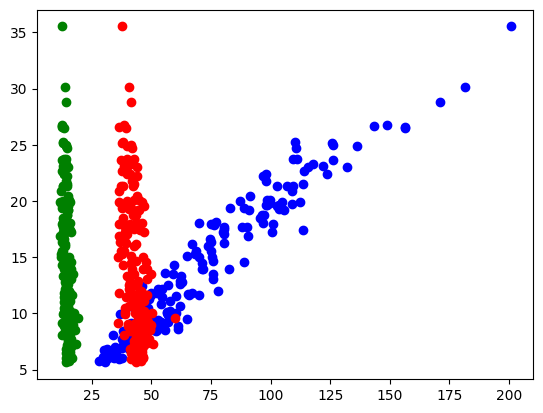

In [43]:
# Lets plot cost vs score and also between MinutestoGoalRatio and ShotsPerGame
plt.scatter(dfSoccer["Cost"], dfSoccer["Score"], c="blue")
plt.scatter(dfSoccer["MinutestoGoalRatio"], dfSoccer["Score"], c="red")
plt.scatter(dfSoccer["ShotsPerGame"], dfSoccer["Score"], c="green")
plt.show()

In [45]:
dfSoccer[["Cost", "MinutestoGoalRatio", "ShotsPerGame", "Score"]].head()

,Cost,MinutestoGoalRatio,ShotsPerGame,Score
0,109.1,37.5,12.3,19.75
1,102.8,38.2,12.7,21.30
2,104.6,36.4,11.6,19.88
3,126.4,37.3,12.6,23.66
4,80.3,41.5,14.0,17.64


In [46]:
x = dfSoccer[["Cost", "MinutestoGoalRatio", "ShotsPerGame"]]
y = dfSoccer["Score"]

x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.75, test_size=0.25, random_state=100)

##### Lets look at statsmodel 

In [47]:
lr = sm.OLS(y_train, x_train).fit()

lr.params
lr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  Score   R-squared (uncentered):                   0.988
Model:                            OLS   Adj. R-squared (uncentered):              0.988
Method:                 Least Squares   F-statistic:                              4128.
Date:                Thu, 01 Jun 2023   Prob (F-statistic):                   2.14e-142
Time:                        08:43:33   Log-Likelihood:                         -291.96
No. Observations:                 151   AIC:                                      589.9
Df Residuals:                     148   BIC:                                      599.0
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Cost                   0.1850      0.004     49.509      0.000       0.178       0.192
MinutestoGoalRatio     0.2943      0.107      2.743      0.007       0.082       0.506
ShotsPerGame          -0.8228      0.314     -2.617      0.010      -1.444      -0.202
==============================================================================
Omnibus:                        1.608   Durbin-Watson:                   1.784
Prob(Omnibus):                  0.447   Jarque-Bera (JB):                1.660
Skew:                           0.240   Prob(JB):                        0.436
Kurtosis:                       2.816   Cond. No.                         216.
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [48]:
#force intercept term
x_train_with_intercept = sm.add_constant(x_train)
lr = sm.OLS(y_train, x_train_with_intercept).fit()
lr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Score   R-squared:                       0.945
Model:                            OLS   Adj. R-squared:                  0.944
Method:                 Least Squares   F-statistic:                     842.1
Date:                Thu, 01 Jun 2023   Prob (F-statistic):           2.43e-92
Time:                        08:44:44   Log-Likelihood:                -274.89
No. Observations:                 151   AIC:                             557.8
Df Residuals:                     147   BIC:                             569.8
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 11.7792      1.928      6.108      0.000       7.968      15.590
Cost                   0.1692      0.004     40.024      0.000       0.161       0.178
MinutestoGoalRatio    -0.0627      0.113     -0.557      0.578      -0.285       0.160
ShotsPerGame          -0.4991      0.287     -1.741      0.084      -1.066       0.067
==============================================================================
Omnibus:                        7.466   Durbin-Watson:                   2.026
Prob(Omnibus):                  0.024   Jarque-Bera (JB):                7.201
Skew:                           0.466   Prob(JB):                       0.0273
Kurtosis:                       3.525   Cond. No.                     1.40e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.4e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [49]:
x = dfSoccer[["Cost", "ShotsPerGame"]]
y = dfSoccer["Score"]

x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.75, test_size=0.25, random_state=100)

x_train_with_intercept = sm.add_constant(x_train)
lr = sm.OLS(y_train, x_train_with_intercept).fit()
lr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Score   R-squared:                       0.945
Model:                            OLS   Adj. R-squared:                  0.944
Method:                 Least Squares   F-statistic:                     1269.
Date:                Thu, 01 Jun 2023   Prob (F-statistic):           7.03e-94
Time:                        09:51:05   Log-Likelihood:                -275.04
No. Observations:                 151   AIC:                             556.1
Df Residuals:                     148   BIC:                             565.1
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           11.2212      1.644      6.825      0.000       7.972      14.470
Cost             0.1697      0.004     41.069      0.000       0.162       0.178
ShotsPerGame    -0.6482      0.102     -6.348      0.000      -0.850      -0.446
==============================================================================
Omnibus:                        7.048   Durbin-Watson:                   2.009
Prob(Omnibus):                  0.029   Jarque-Bera (JB):                6.712
Skew:                           0.455   Prob(JB):                       0.0349
Kurtosis:                       3.487   Cond. No.                     1.08e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.08e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

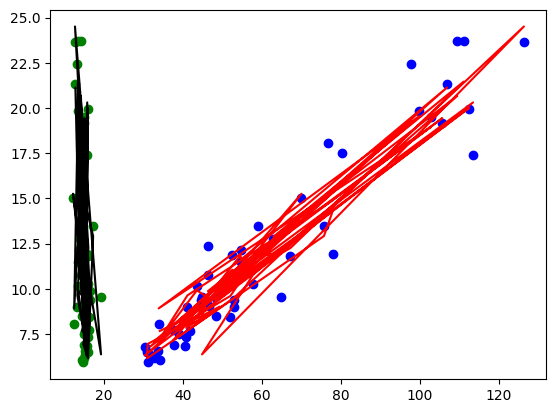

In [56]:
x_test_with_intercept = sm.add_constant(x_test)
y_test_fitted = lr.predict(x_test_with_intercept)


plt.scatter(x_test[["Cost"]], y_test, c="blue")
plt.plot(x_test[["Cost"]], y_test_fitted, c='red')

plt.scatter(x_test[["ShotsPerGame"]], y_test, c="green")
plt.plot(x_test[["ShotsPerGame"]], y_test_fitted, c="black")
plt.show()

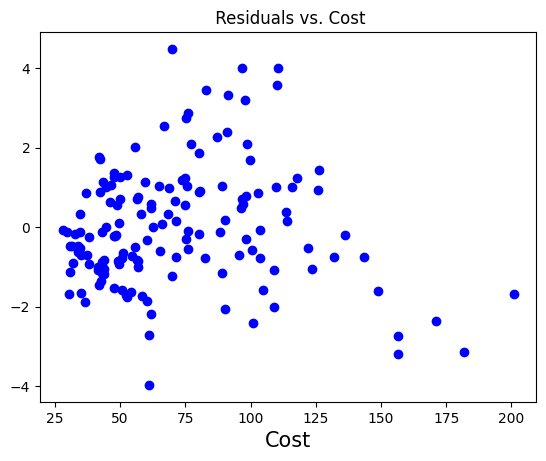

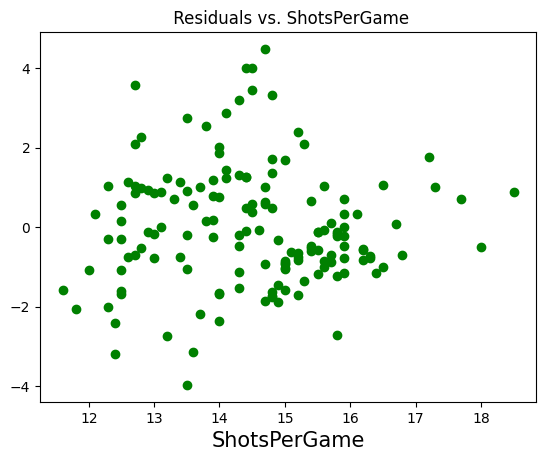

In [57]:
# Build Predictions on Training Data
predictions_y = lr.predict(x_train_with_intercept)
r_i = (y_train - predictions_y)

#Residuals vs. predictor in training data
plt.title(' Residuals vs. Cost')
plt.xlabel('Cost',fontsize=15)
plt.scatter(x_train[["Cost"]], r_i, c="blue")
plt.show()

#Residuals vs. predictor in training data
plt.title(' Residuals vs. ShotsPerGame')
plt.xlabel('ShotsPerGame',fontsize=15)
plt.scatter(x_train[["ShotsPerGame"]], r_i, c="green")
plt.show()

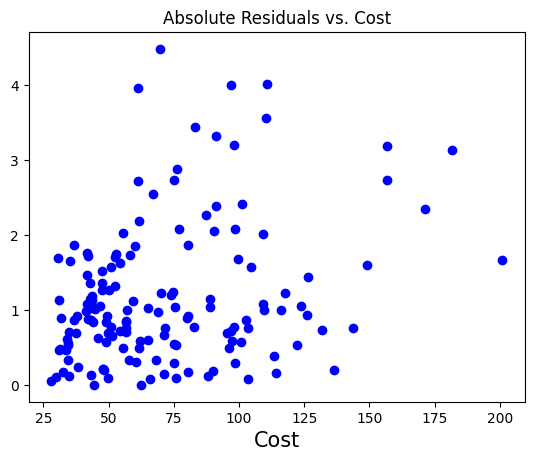

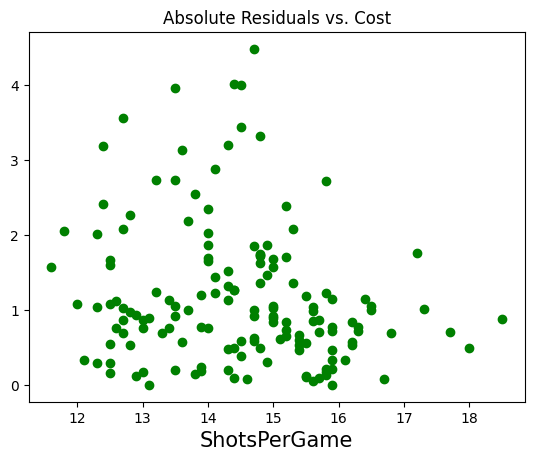

In [58]:
#Absolute residuals against predictor
abs_r_i = np.abs(y_train - predictions_y)
plt.title('Absolute Residuals vs. Cost')
plt.xlabel('Cost',fontsize=15)
plt.scatter(x_train[["Cost"]], abs_r_i, c="blue")
plt.show()

#Absolute residuals against predictor
abs_r_i = np.abs(y_train - predictions_y)
plt.title('Absolute Residuals vs. Cost')
plt.xlabel('ShotsPerGame',fontsize=15)
plt.scatter(x_train[["ShotsPerGame"]], abs_r_i, c="green")
plt.show()

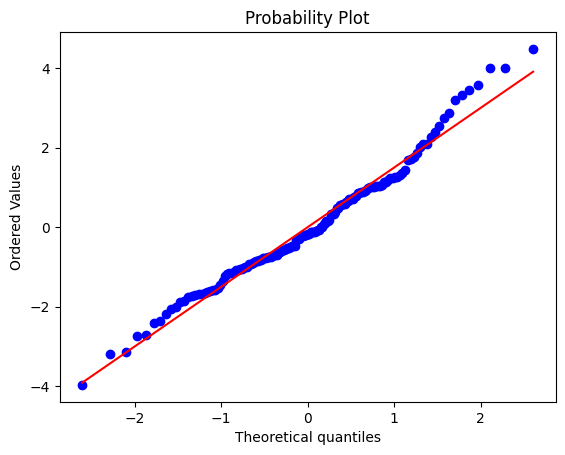

In [60]:
#Normality plot
scipy.stats.probplot(r_i,plot=plt)
plt.show()

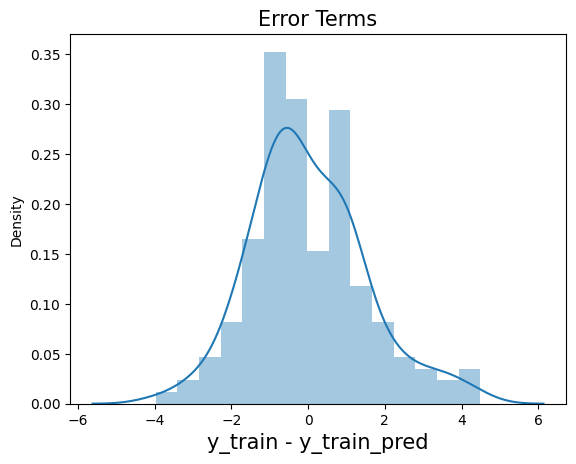

In [61]:
#Tails might be a little heavy, but overall no clear reason to reject normality expectations
# Evaluate normality through histogram of residuals
# Plotting the histogram using the residual values
fig = plt.figure()
sns.distplot(r_i, bins = 15)
plt.title('Error Terms', fontsize = 15)
plt.xlabel('y_train - y_train_pred', fontsize = 15)
plt.show()

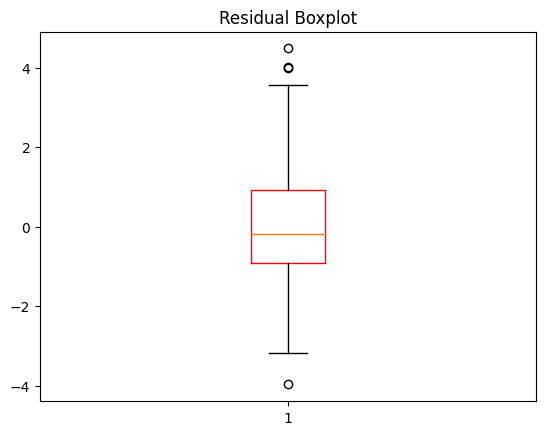

In [62]:
#Boxplot for outliers
# plot
plt.boxplot(r_i, boxprops=dict(color='red'))
plt.title('Residual Boxplot');

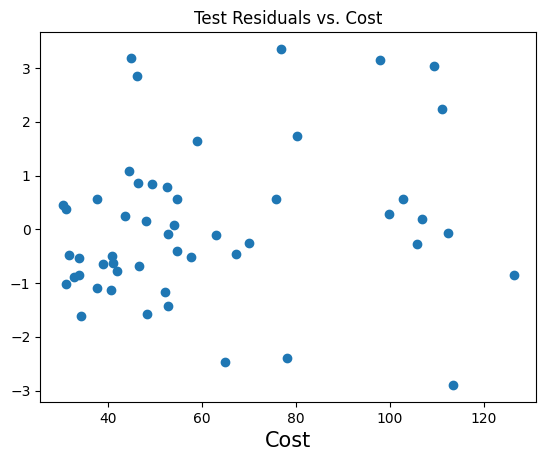

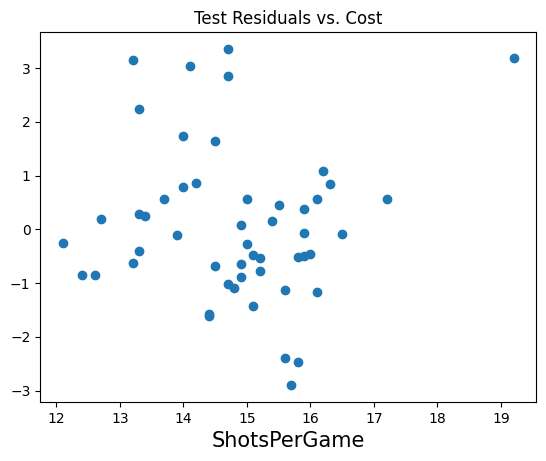

In [63]:
#Demo of how to deal with non-constant variance through transformations

test_residuals=(y_test-y_test_fitted)
len(y_test)
len(y_test_fitted)
len(test_residuals)

#Residuals vs. predictor in test set
plt.title('Test Residuals vs. Cost')
plt.xlabel('Cost',fontsize=15)
plt.scatter(x_test[["Cost"]], test_residuals)
plt.show()

#Residuals vs. predictor in test set
plt.title('Test Residuals vs. Cost')
plt.xlabel('ShotsPerGame',fontsize=15)
plt.scatter(x_test[["ShotsPerGame"]], test_residuals)
plt.show()

#Some evidence of non-constant variance


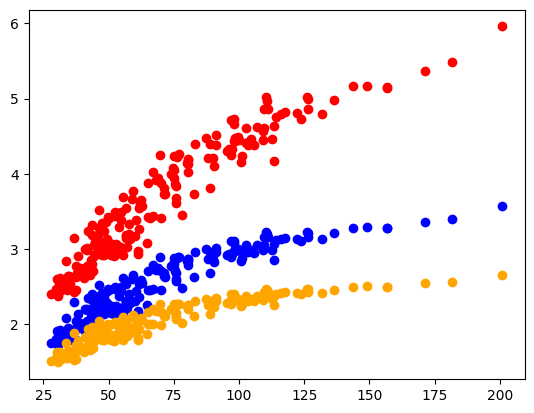

In [65]:
#

#Try sqrt
sqrt_y=np.sqrt(y)
plt.scatter(x[["Cost"]], sqrt_y,color='red');

#Try ln
ln_y=np.log(y)
plt.scatter(x[["Cost"]], ln_y,color='blue');


#Let's try a BC transformation

#Box Cox procedure on all cost
bc_y=list(stats.boxcox(y))
bc_y=bc_y[0]
plt.scatter(x[["Cost"]], bc_y,color='orange');

#Overall, most satisfied with the sqrt transformation

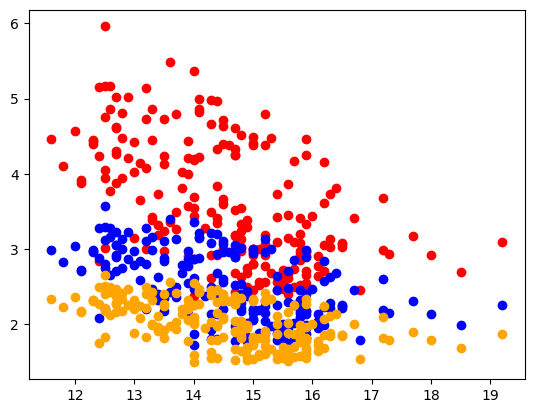

In [66]:
#

#Try sqrt
sqrt_y=np.sqrt(y)
plt.scatter(x[["ShotsPerGame"]], sqrt_y,color='red');

#Try ln
ln_y=np.log(y)
plt.scatter(x[["ShotsPerGame"]], ln_y,color='blue');


#Let's try a BC transformation

#Box Cox procedure on all cost
bc_y=list(stats.boxcox(y))
bc_y=bc_y[0]
plt.scatter(x[["ShotsPerGame"]], bc_y,color='orange');

#Overall, most satisfied with the sqrt transformation

In [67]:
#Run regression on this set

x_train, x_test, y_train, y_test = train_test_split(x, sqrt_y, train_size = 0.75,
                                                    test_size = 0.25, random_state = 100)


#force intercept term
x_train_with_intercept = sm.add_constant(x_train)
lr = sm.OLS(y_train, x_train_with_intercept).fit()
lr.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Score   R-squared:                       0.916
Model:                            OLS   Adj. R-squared:                  0.914
Method:                 Least Squares   F-statistic:                     802.0
Date:                Thu, 01 Jun 2023   Prob (F-statistic):           3.78e-80
Time:                        10:05:01   Log-Likelihood:               -0.61157
No. Observations:                 151   AIC:                             7.223
Df Residuals:                     148   BIC:                             16.27
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            3.5528      0.267     13.303      0.000       3.025       4.081
Cost             0.0215      0.001     32.065      0.000       0.020       0.023
ShotsPerGame    -0.1000      0.017     -6.030      0.000      -0.133      -0.067
==============================================================================
Omnibus:                        0.027   Durbin-Watson:                   1.957
Prob(Omnibus):                  0.987   Jarque-Bera (JB):                0.053
Skew:                          -0.028   Prob(JB):                        0.974
Kurtosis:                       2.927   Cond. No.                     1.08e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.08e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [68]:
lr.params

const           3.552783
Cost            0.021523
ShotsPerGame   -0.100033
dtype: float64

const           3.552783
Cost            0.021523
ShotsPerGame   -0.100033
dtype: float64


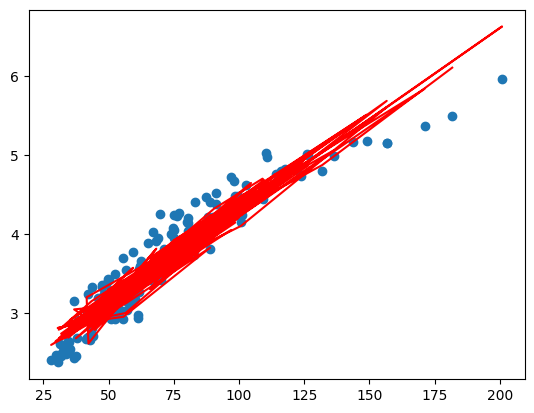

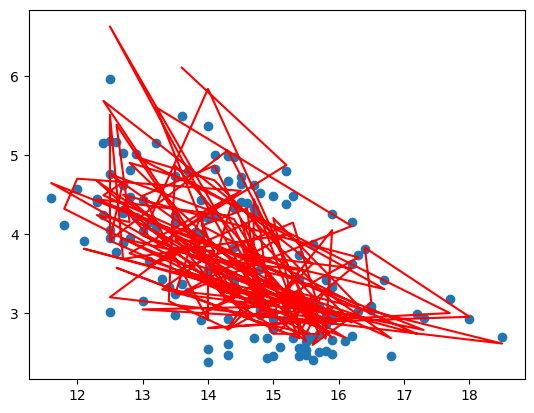

In [71]:
#Extract the B0, B1
print(lr.params)
b0=lr.params[0]
b1=lr.params[1]
b2=lr.params[2]

#Plot the fitted line on training data
plt.scatter(x_train["Cost"], y_train)
plt.plot(x_train["Cost"], b0+ b1*x_train["Cost"] + b2*x_train["ShotsPerGame"], 'r')
plt.show()

#Plot the fitted line on training data
plt.scatter(x_train["ShotsPerGame"], y_train)
plt.plot(x_train["ShotsPerGame"], b0+ b1*x_train["Cost"] + b2*x_train["ShotsPerGame"], 'r')
plt.show()

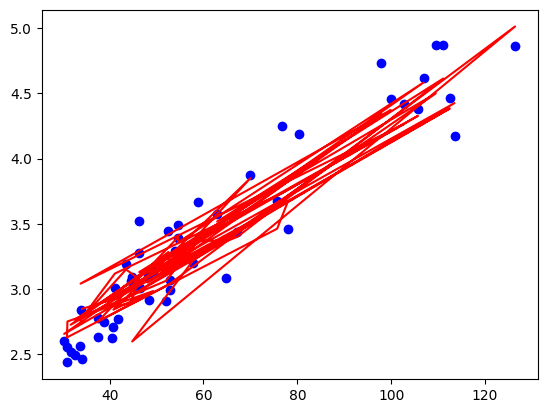

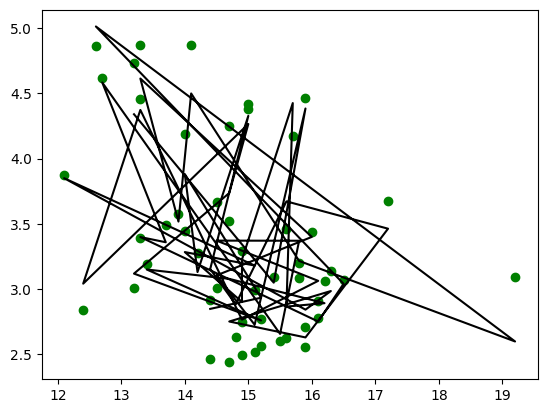

51 51 51


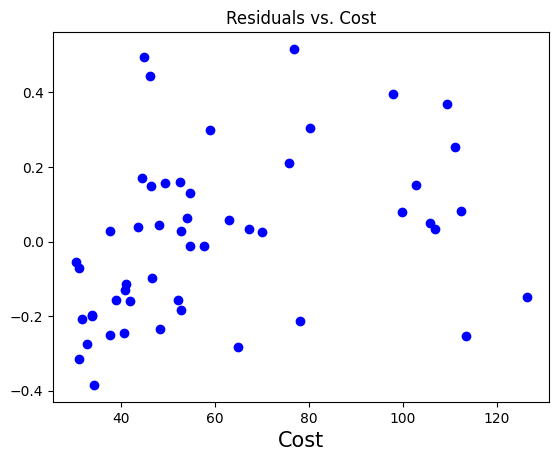

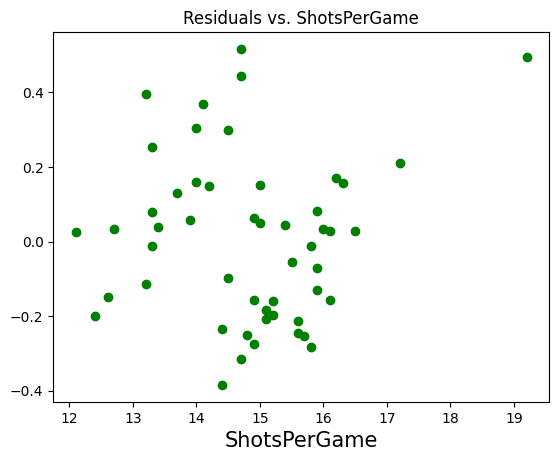

In [73]:
#Plot the fitted line on test data

x_test_with_intercept = sm.add_constant(x_test)
y_test_fitted = lr.predict(x_test_with_intercept)


plt.scatter(x_test["Cost"], y_test, c="blue")
plt.plot(x_test["Cost"], y_test_fitted, c='red')
plt.show()

plt.scatter(x_test["ShotsPerGame"], y_test, c="green")
plt.plot(x_test["ShotsPerGame"], y_test_fitted, c='black')
plt.show()

#Evaluate variance
#Diagnostics
test_residuals=(y_test-y_test_fitted)
print(len(y_test), len(y_test_fitted), len(test_residuals))

#Residuals vs. predictor
plt.title('Residuals vs. Cost')
plt.xlabel('Cost',fontsize=15)
plt.scatter(x_test["Cost"], test_residuals, c="blue")
plt.show()

#Residuals vs. predictor
plt.title('Residuals vs. ShotsPerGame')
plt.xlabel('ShotsPerGame',fontsize=15)
plt.scatter(x_test["ShotsPerGame"], test_residuals, c="green")
plt.show()

#Non-constant variance reduced, but we also reduced our coefficient of determination